In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
import scipy as scp
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy, TD3Policy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode
from tianshou.exploration import GaussianNoise

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

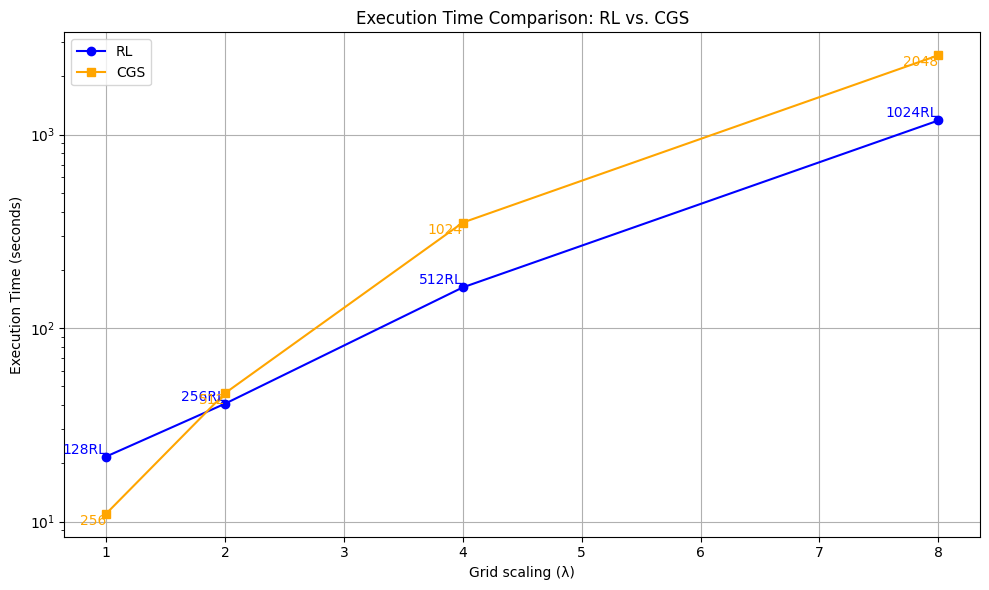

In [3]:
#speedup plot
#RL_times = np.array([30.09, 50.17, 177.05, 1353.09])
RL_times = np.array([21.67, 40.64, 162.25, 1182.65])
CGS_times = np.array([10.97, 46.06, 350.94, 2569.55])

RL_names = ["128RL", "256RL", "512RL", "1024RL"]
CGS_names = ["256", "512", "1024", "2048"]

lamb = np.array([1,2,4,8])


# Plot
plt.figure(figsize=(10, 6))
plt.plot(lamb, RL_times, 'o-', label='RL', color='blue')
plt.plot(lamb, CGS_times, 's-', label='CGS', color='orange')

# Adding labels to each point
for i, (x, y, rl_name, cgs_name) in enumerate(zip(lamb, RL_times, RL_names, CGS_names)):
    plt.text(x, y, rl_name, color='blue', ha='right', va='bottom')
    plt.text(x, CGS_times[i], cgs_name, color='orange', ha='right', va='top')

# Labels and title
plt.xlabel('Grid scaling (λ)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison: RL vs. CGS')
plt.legend()
plt.grid(True)
plt.yscale("log")  # Use log scale for better visibility of data spread
plt.tight_layout()
plt.show()


# load and look at trained policz

In [4]:
# global action learned with ppo stabalizes run
DUMP_PATH = "dump/Kolmogorov20_ppo_cgs1_fgs1/"
ID = "20241016-092258"

In [3]:
# global action learned with ppo stabalizes run 2.0
DUMP_PATH = "dump/Kolmogorov22_global_ppo_cgs1_fgs16/"
ID = "20241030-115319"

In [9]:
# early peak of TD3 for local independent actions
DUMP_PATH = "dump/Kolmogorov22_td3_cgs1_fgs1/"
ID = "20241019-093432"

In [3]:
# PPO run for local actions and scaled loss
DUMP_PATH = "dump/Kolmogorov22_ppo_cgs1_fgs16/"
ID = "20241021-110311"

In [11]:
# PPO run for interpolating agents
DUMP_PATH = "dump/Kolmogorov22_ppo_cgs1_fgs16/"
ID = "20241022-065823"

In [3]:
# PPO run for interpolating agents seed=66
DUMP_PATH = "dump/Kolmogorov24_ppo_cgs1_fgs16/"
ID = "20241105-150930"

In [4]:
#policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))
with open(DUMP_PATH+'config_'+ID+'.pkl', 'rb') as f:
    args = pickle.load(f)

In [5]:
 #######################################################################################################
####### environments ##################################################################################
#######################################################################################################
#seeds = np.array([102])
seeds = np.array([33])

#assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds
val_seeds = seeds
#test_seeds = np.array([69, 33, 420])

#train_env = KolmogorovEnvironment22_visualization(seeds=train_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
#test_env = KolmogorovEnvironment22_visualization(seeds=val_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

#train_env = KolmogorovEnvironment22_higher(seeds=train_seeds, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2, Re=1e5)
#test_env = KolmogorovEnvironment22_higher(seeds=val_seeds, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2, Re=1e5)

#train_env = KolmogorovEnvironment24_decaying(seeds=train_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1, N_agents=args.num_agents)
#test_env = KolmogorovEnvironment24_decaying(seeds=val_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1, N_agents=args.num_agents)

#train_env = KolmogorovEnvironment24(seeds=train_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1, N_agents=args.num_agents)
#test_env = KolmogorovEnvironment24(seeds=val_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1, N_agents=args.num_agents)


#train_env = KolmogorovEnvironment24(seeds=train_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2, N_agents=2*args.num_agents)
#test_env = KolmogorovEnvironment24(seeds=val_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2, N_agents=2*args.num_agents)

#train_env = KolmogorovEnvironment22_decay(seeds=train_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
#test_env = KolmogorovEnvironment22_decay(seeds=val_seeds, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

train_env = KolmogorovEnvironment22(seeds=train_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
test_env = KolmogorovEnvironment22(seeds=val_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

#train_env = KolmogorovEnvironment22_global(seeds=train_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
#test_env = KolmogorovEnvironment22_global(seeds=val_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

#train_env = KolmogorovEnvironment22_global_decay(seeds=train_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)
#test_env = KolmogorovEnvironment22_global_decay(seeds=val_seeds, Re=1e4, max_episode_steps=20025, step_factor=1, fgs_lamb=16, cgs_lamb=1)

#train_env = KolmogorovEnvironment22_global(seeds=train_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2)
#test_env = KolmogorovEnvironment22_global(seeds=val_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2)

#train_env = KolmogorovEnvironment22_global(seeds=train_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2)
#test_env = KolmogorovEnvironment22_global(seeds=val_seeds, Re=1e5, max_episode_steps=2*20025, step_factor=1, fgs_lamb=16, cgs_lamb=2)


Re=10000.0, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842
Re=10000.0, m_prime=20025, T=227.00832667993888, omega=1.9996472117476842


In [6]:
#######################################################################################################
####### PPO Policy ########################################################################################
#######################################################################################################
actor = local_actor_net(in_channels=6, device=device, nx=256).to(device)
#actor = central_actor_net2(in_channels=6, device=device, nx=128).to(device)
critic = central_critic_net2(in_channels=6, device=device, nx=128).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = PPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=True,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    vf_coef = args.vf_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [6]:
#######################################################################################################
####### Interpolating PPO Policy ########################################################################################
#######################################################################################################

actor = FullyConvNet_interpolating_agents(in_channels=6, N=args.num_agents, device=device).to(device)
#actor = central_actor_net2(in_channels=6, device=device).to(device)
critic = central_critic_net2(in_channels=6, device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.AdamW(actor_critic.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
#dist = ElementwiseNormal

#if args.lr_decay == True:
#    # decay learning rate to 0 linearly
#    max_update_num = np.ceil(args.step_per_epoch / args.step_per_collect) * args.max_epoch
#    lr_scheduler = LambdaLR(optim, lr_lambda=lambda epoch: 1 - epoch / max_update_num)


policy = PPOPolicy(actor=actor,
    critic=critic,
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    advantage_normalization = args.advantage_normalization,
    value_clip = args.value_clip,
    deterministic_eval=args.deterministic_eval,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    vf_coef = args.vf_coef,
    eps_clip=args.clip_range,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
    recompute_advantage=args.recompute_advantage,
    #lr_scheduler=lr_scheduler,
)

In [8]:
#load trained bolicy
policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))
#policy.load_state_dict(torch.load(DUMP_PATH+"best_policy.pth"))

<All keys matched successfully>

In [9]:
state, _ = train_env.reset()

In [20]:
jnp.array(state).shape

(128, 128, 6)

In [16]:
train_env.step(np.ones((128,128,1)))

(array([[[ 1.00074673e+00, -3.03775771e-03,  7.55908340e-02,
           9.22794978e-04, -7.19734817e-04, -8.86958966e-04],
         [ 1.00070226e+00,  1.62832975e-01,  2.00914398e-01,
           1.56447699e-03, -5.11756341e-04, -1.47611450e-03],
         [ 1.00060785e+00,  3.56472880e-01,  3.57850790e-01,
           1.75472221e-03, -4.54024004e-04, -1.70923828e-03],
         ...,
         [ 1.00056887e+00, -1.97698906e-01,  8.92637223e-02,
          -8.14248051e-04, -1.03195617e-03,  7.60931347e-04],
         [ 1.00062954e+00, -1.82005912e-01,  3.23359929e-02,
          -4.47037688e-04, -1.01153867e-03,  4.01663856e-04],
         [ 1.00063729e+00, -1.23439334e-01,  2.22616103e-02,
           1.50073116e-04, -8.84164474e-04, -1.72096683e-04]],
 
        [[ 1.00069308e+00, -5.28576970e-02,  1.47608280e-01,
          -6.49014037e-05, -1.00800826e-03,  4.15438481e-05],
         [ 1.00065112e+00,  4.63977046e-02,  1.78951710e-01,
           6.03158784e-04, -8.17348773e-04, -6.22809806e-04],

In [8]:
def interpolate_actions(actions):
    N = args.num_agents
    dist = int(128 // N)  # distance between agents
    half_dist = int(dist//2)
    actions = np.pad(actions, pad_width=1, mode='wrap')
    actions = actions.flatten()
    coord = np.array([(i*dist, j*dist) for i in range(N+2) for j in range(N+2)])
    grid_x, grid_y = np.meshgrid(np.arange(128+dist), np.arange(128+dist))
    interpolated_actions = scp.interpolate.griddata(coord, actions, (grid_x, grid_y), method='cubic')
    actual_actions = interpolated_actions[half_dist:(128+half_dist), half_dist:(128+half_dist)]
    
    return actual_actions

def interpolate_actions256(actions):
    N = 2*args.num_agents
    dist = int(256 // N)  # distance between agents
    half_dist = int(dist//2)
    actions = np.pad(actions, pad_width=1, mode='wrap')
    actions = actions.flatten()
    coord = np.array([(i*dist, j*dist) for i in range(N+2) for j in range(N+2)])
    grid_x, grid_y = np.meshgrid(np.arange(256+dist), np.arange(256+dist))
    interpolated_actions = scp.interpolate.griddata(coord, actions, (grid_x, grid_y), method='cubic')
    actual_actions = interpolated_actions[half_dist:(256+half_dist), half_dist:(256+half_dist)]
    
    return actual_actions

0.9030144864886535


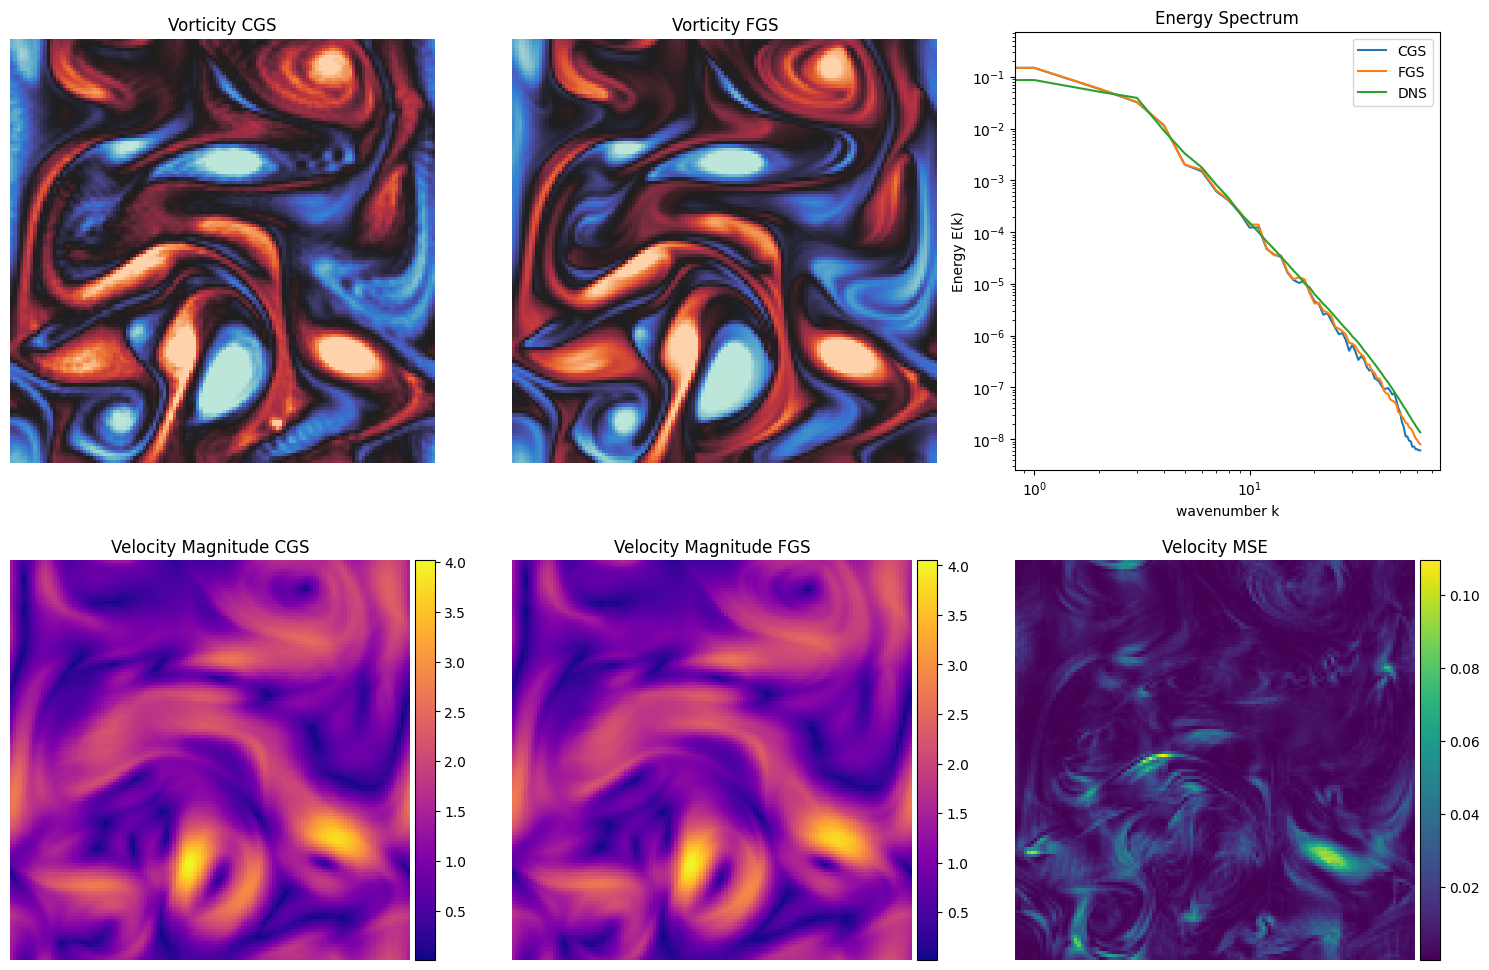

0.8828956961668689


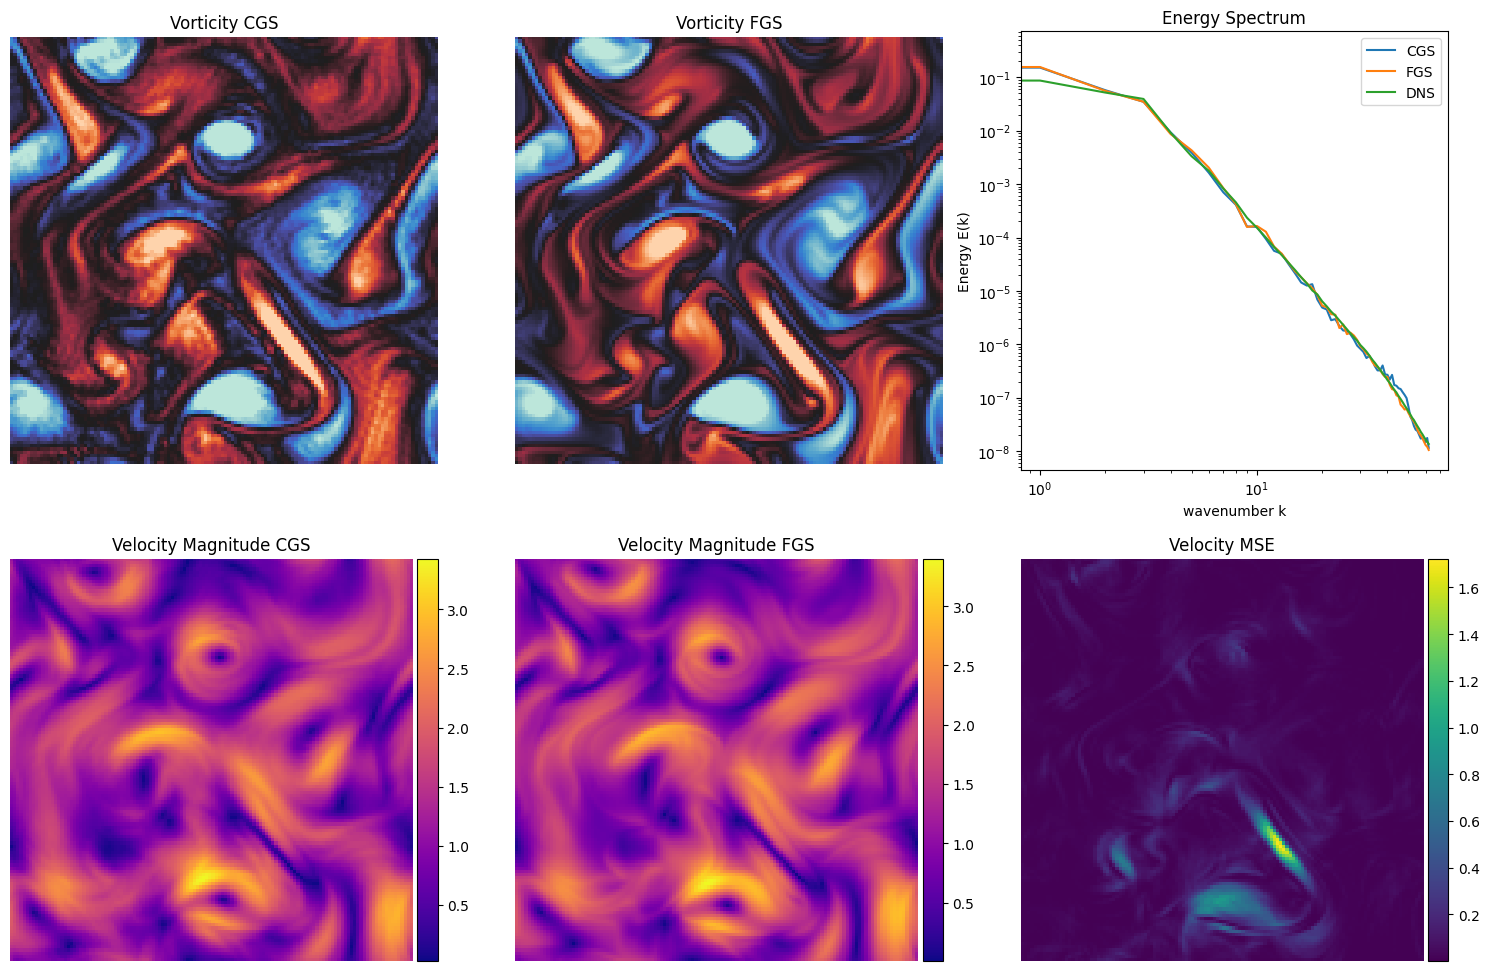

0.885004939566605


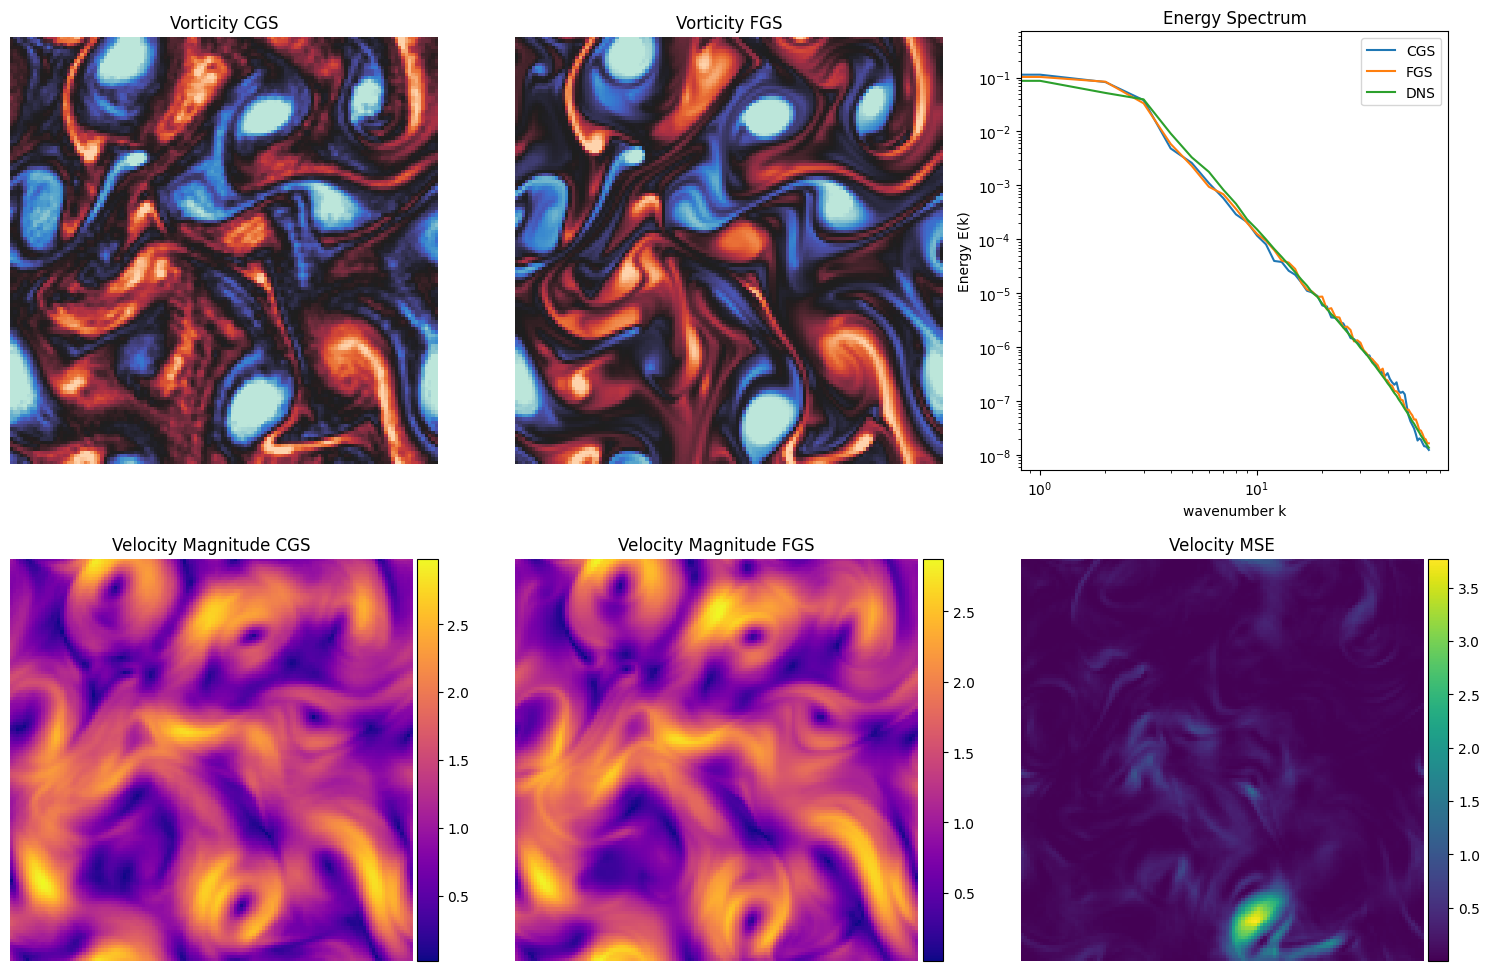

KeyboardInterrupt: 

In [11]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    #logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    action = interpolate_actions(action)
    act = policy.map_action(action)
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    step += 1
    if step%2000==0:
        print(rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        #print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        #print(f"rew- mean{rew.mean()} +- {rew.std()} in [{rew.min()},{rew.max()}]")
        test_env.render()
        #v = test_env.get_vorticity()
        #plot_policy(logits[0].reshape(128,128), logits[1].reshape(128,128), v)
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

In [24]:
print(np.array(acts).mean())
print(np.array(acts).std())

-0.004964767
5.6448956e-05


In [9]:
def plot_policy(mean, std, v):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal')
    im2 = axs[1].imshow(std, cmap='viridis', aspect='equal')
    im3 = axs[2].imshow(v, cmap=sn.cm.icefire, vmin=-10, vmax=10)
    #axs[2].invert_xaxis()


    axs[0].set_title(r"policy mean $\mu$")
    axs[1].set_title(r"policy std $\sigma$")
    #axs[2].set_title(r"sampled actions $a \sim \mathcal{N}(\mu, \sigma)$")
    axs[2].set_title(r"vorticity field")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_xticks([])


    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
    plt.show()

In [10]:
def plot_action(mean, v):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal')
    im2 = axs[1].imshow(v, cmap=sn.cm.icefire, vmin=-10, vmax=10)
    #axs[2].invert_xaxis()

    axs[0].set_title(r"policy mean $\mu$")
    axs[1].set_title(r"vorticity field")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])

    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    plt.show()

def save_actions(mean, v, fname):
    N = args.num_agents
    dist = int(128 // N)  # distance between agents
    half_dist = int(dist//2)
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', vmin=-0.068, vmax=-0.062)
    im2 = axs[1].imshow(v, cmap=sn.cm.icefire, vmin=-10, vmax=10)
    #axs[2].invert_xaxis()

    coord_agents = np.stack(np.meshgrid(np.arange(N) * dist + half_dist, np.arange(N) * dist + half_dist), -1).reshape(-1, 2)
    axs[0].scatter(coord_agents[:, 0], coord_agents[:, 1], color='black', label='Agents', edgecolor='black', facecolors='none', s=20, zorder=5)

    axs[0].set_title(r"policy mean $\mu$")
    axs[1].set_title(r"vorticity field")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])

    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    #plt.show()
    plt.savefig(f'visuals/'+fname+'.png', dpi=100)
    plt.close()

In [14]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
act_means = []
act_maxs = []
act_mins = []
act_stds = []
std_means = []
episode_is_over = False
act = np.ones(test_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    action = interpolate_actions(action)
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    act_means.append(act.reshape(128,128).mean())
    act_mins.append(act.reshape(128,128).min())
    act_maxs.append(act.reshape(128,128).max())
    act_stds.append(act.reshape(128,128).std())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    reward += rew
    step += 1
    if step%4000==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        print(f"rew- mean{rew.mean()} +- {rew.std()} in [{rew.min()},{rew.max()}]")
        test_env.render()
        v = test_env.get_vorticity()
        plot_action(action, v)
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

TypeError: 'tuple' object is not callable

In [20]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
act_means = []
act_maxs = []
act_mins = []
act_stds = []
std_means = []
episode_is_over = False
act = np.ones(test_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    #action = interpolate_actions256(action)
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    #act_means.append(act.reshape(256,256).mean())
    #act_mins.append(act.reshape(256,256).min())
    #act_maxs.append(act.reshape(256,256).max())
    #act_stds.append(act.reshape(256,256).std())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    reward += rew
    step += 1
    if step%2000==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        print(f"rew- mean{rew.mean()} +- {rew.std()} in [{rew.min()},{rew.max()}]")
        test_env.render()
        v = test_env.get_vorticity()
        plot_action(action, v)
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

mean=-0.06145640090107918, std=0.17894499003887177, act=-0.06145640090107918, scaled act = -0.0003072820254601538
rew- mean0.9403206142903583 +- 0.0 in [0.9403206142903583,0.9403206142903583]


AttributeError: 'KolmogorovEnvironment24' object has no attribute 'u2'

In [16]:
action.shape

(256, 256)

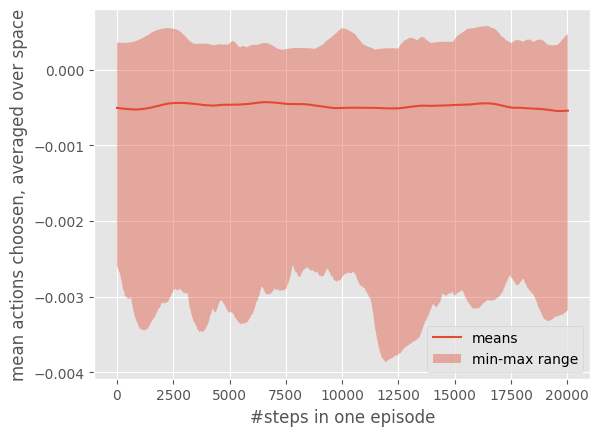

In [11]:
act_means = np.array(act_means)
act_maxs =np.array( act_maxs)
act_mins =np.array( act_mins)
act_stds =np.array( act_stds)
std_means = np.array(std_means)

#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.fill_between(t, act_mins, act_maxs, alpha=0.4, label="min-max range")
#plt.fill_between(t, act_means-act_stds, act_means+act_stds, alpha=0.4, label="min-max range")
#plt.plot(t, act_mins, label="mins")
#plt.plot(t, act_maxs, label="maxs")
#plt.ylim([0.995,1.005])
plt.legend()
plt.xlabel("#steps in one episode")
plt.ylabel("mean actions choosen, averaged over space")
plt.show()

In [8]:
args.seed

66

### Run visualization simulation with actions

In [8]:
Re = 10000
N = 128
T = 227
seed = 33
upsi = 1

In [9]:
if not os.path.exists(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_scaled_policy"):
    os.makedirs(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_scaled_policy")
os.chdir(f"re{int(Re)}_T{int(T)}_N{int(N)}_S{seed}_U{upsi}_dump_scaled_policy")
# remove all .png files in the current directory

In [11]:
!pwd

/home/pfischer/CNN-MARL_closure_model_discovery/re10000_T227_N128_S33_U1_dump_scaled_policy


/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
m = 20025
io_rate = 8 #32
for step in tqdm(range(m)):
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    #logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    if step%io_rate==0:
       #save velocity field as npy
        fname = "klmgrv"
        fname = "velocity_" + fname
        fname = fname + "_" + f"s{seed}"
        fname = fname + "_" + str(step).zfill(6)
        #u1 = downsample_field(test_env.u1, 2)
        u1 = test_env.u1
        np.save(fname, u1)

    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

#print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

100%|██████████| 20025/20025 [05:58<00:00, 55.88it/s]

truncated


In [14]:
reward

17089.026881131776

In [10]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
m = 2*20025
io_rate = 2*32
for step in tqdm(range(m)):
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    #logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    if step%io_rate==0:
       #save velocity field as npy
        fname = "klmgrv"
        fname = "velocity_" + fname
        fname = fname + "_" + f"s{seed}"
        fname = fname + "_" + str(step).zfill(6)
        #u1 = downsample_field(test_env.u1, 2)
        u1 = test_env.u1
        np.save(fname, u1)

    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

#print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

  4%|▍         | 1557/40050 [00:10<04:27, 143.69it/s]


KeyboardInterrupt: 

In [13]:
#play one episode of T=227 and save npy files at same frequency as visualizations
print(np.array(acts).mean())
print(np.array(acts).std())

-0.0003056232
1.44572705e-05


### save mean action plot

In [14]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
acts = []
trivial_action = np.zeros(train_env.action_space.shape)
episode_is_over = False
act = np.ones(test_env.action_space.shape)
m = 2*20025
io_rate = 2*32
for step in tqdm(range(m)):
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    int_action = interpolate_actions(action)
    act = policy.map_action(action)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    #obs, rew, terminated, truncated, inf = test_env.step(trivial_action)
    acts.append(act)
    reward += rew
    if step%io_rate==0:
       #save velocity field as npy
        fname = "klmgrv"
        fname = "actions_" + fname
        fname = fname + "_" + f"s{102}"
        fname = fname + "_" + str(step).zfill(6)

        v = test_env.get_vorticity()
        #save_actions(logits[0].reshape(128,128), v, fname)
        save_actions(int_action, v, fname)

    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

#print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

  0%|          | 0/20025 [00:00<?, ?it/s]

100%|██████████| 20025/20025 [10:44<00:00, 31.06it/s]

truncated


In [ ]:
# trained global action
#steps = 5000, Total Reward = 3959.149094250915
#steps = 1980, Total Reward = 1629.2470463411048
#steps = 1979, Total Reward = 1628.4114643869793
#steps = 495, Total Reward = 321.78269335891486

#trivial action
#steps = 1980, Total Reward = 1522.6651627185977
#steps = 1980, Total Reward = 1522.6651627185977
#steps = 1979, Total Reward = 1622.0979063768702
#steps = 495, Total Reward = 321.72114564304064


In [11]:
np.array(acts).mean()

-0.00022932581

### look at torch distribution

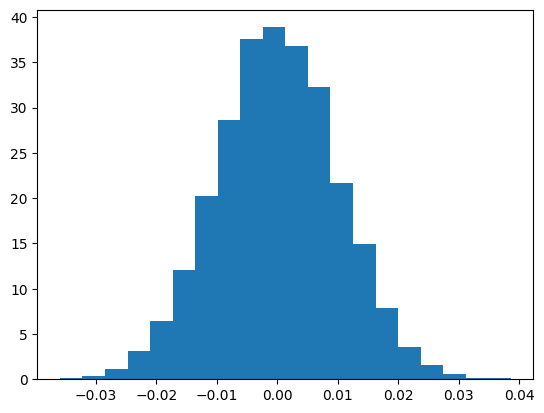

In [5]:
dist = torch.distributions.Normal
samples = np.array([dist(0,0.01).sample() for _ in range(10000)])

plt.figure()
plt.hist(samples, bins=20, density=True)
plt.show()

In [6]:
mean = torch.zeros((1,2,2))
std = torch.ones((1,2,2))
sample = dist(mean,std).sample()
print(sample)
print(dist(mean,std).log_prob(sample))

tensor([[[ 0.3783,  1.7652],
         [ 0.1254, -1.5088]]])
tensor([[[-0.9905, -2.4769],
         [-0.9268, -2.0572]]])


In [7]:
dist2 = ElementwiseNormal
dist2.marl = True
print(dist2(mean,std).log_prob(sample))

tensor([[-0.9905, -2.4769],
        [-0.9268, -2.0572]])


### develop interpolating agents

In [13]:
N_agents = 2
nx = train_env.cgs.nx
ny = train_env.cgs.ny

In [14]:
b = nx/N_agents #distance between agents
coord = np.array([(b//2+i*b, b//2+j*b) for i in range(N_agents) for j in range(N_agents)])
#xx, yy = coord[:, 0], coord[:, 1]

In [15]:
coord

array([[32., 32.],
       [32., 96.],
       [96., 32.],
       [96., 96.]])

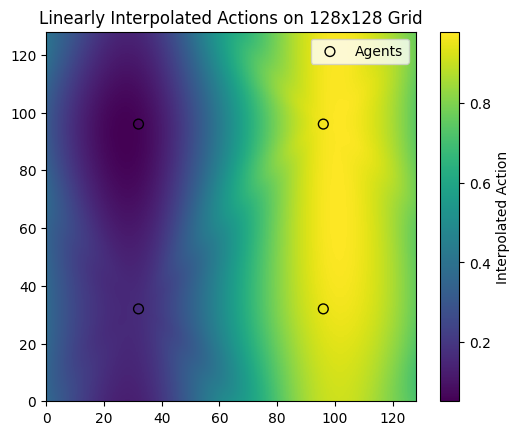

In [7]:
N_agents = 2
dist = int(128 // N_agents)  # distance between agents
half_dist = int(dist//2)
actions = np.random.rand(N_agents,N_agents)
actions = np.pad(actions, pad_width=1, mode='wrap')

actions = actions.flatten()
coord = np.array([(i*dist, j*dist) for i in range(N_agents+2) for j in range(N_agents+2)])
grid_x, grid_y = np.meshgrid(np.arange(128+dist), np.arange(128+dist))
interpolated_actions = scp.interpolate.griddata(coord, actions, (grid_x, grid_y), method='cubic')
actual_actions = interpolated_actions[half_dist:(128+half_dist), half_dist:(128+half_dist)]

# Plotting
plt.imshow(actual_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.colorbar(label='Interpolated Action')
plt.title('Linearly Interpolated Actions on 128x128 Grid')

# Plot agent locations with smaller size and only circle borders
coord_agents = np.stack(np.meshgrid(np.arange(N_agents) * dist + half_dist, np.arange(N_agents) * dist + half_dist), -1).reshape(-1, 2)
plt.scatter(coord_agents[:, 0], coord_agents[:, 1], color='black', label='Agents', edgecolor='black', facecolors='none', s=50, zorder=5)


# Add legend and show the plot
plt.legend()
plt.show()

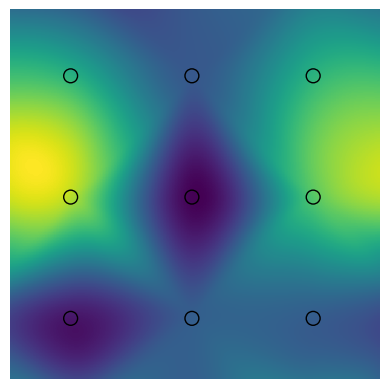

In [14]:
N_agents = 3
dist = int(128 // N_agents)  # distance between agents
half_dist = int(dist//2)
actions = np.random.rand(N_agents,N_agents)
actions = np.pad(actions, pad_width=1, mode='wrap')

actions = actions.flatten()
coord = np.array([(i*dist, j*dist) for i in range(N_agents+2) for j in range(N_agents+2)])
grid_x, grid_y = np.meshgrid(np.arange(128+dist), np.arange(128+dist))
interpolated_actions = scp.interpolate.griddata(coord, actions, (grid_x, grid_y), method='cubic')
actual_actions = interpolated_actions[half_dist:(128+half_dist), half_dist:(128+half_dist)]

# Plotting
plt.imshow(actual_actions, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')

# Plot agent locations with smaller size and only circle borders
coord_agents = np.stack(np.meshgrid(np.arange(N_agents) * dist + half_dist, np.arange(N_agents) * dist + half_dist), -1).reshape(-1, 2)
plt.scatter(coord_agents[:, 0], coord_agents[:, 1], color='black', label='Agents', edgecolor='black', facecolors='none', s=100, zorder=5)


# Add legend and show the plot
#plt.legend()
plt.axis("off")
plt.show()

In [32]:
raw = np.zeros_like(actual_actions)
colors = np.zeros_like(coord_agents)
for (a,b) in coord_agents:
    print(a,b)
    raw[a,b] = actual_actions[a,b]

21 21
63 21
105 21
21 63
63 63
105 63
21 105
63 105
105 105


In [25]:
raw[coord_agents] = actual_actions[coord_agents]

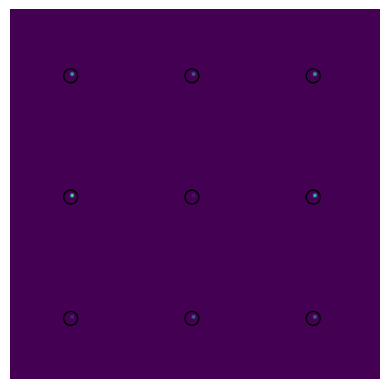

In [31]:
# Plotting
#plt.imshow(actual_actions[1:10,1:10], extent=(0, 128, 0, 128), origin='lower', cmap='viridis')
plt.imshow(raw, extent=(0, 128, 0, 128), origin='lower', cmap='viridis')

# Plot agent locations with smaller size and only circle borders
coord_agents = np.stack(np.meshgrid(np.arange(N_agents) * dist + half_dist, np.arange(N_agents) * dist + half_dist), -1).reshape(-1, 2)
plt.scatter(coord_agents[:, 0], coord_agents[:, 1], color='black', label='Agents', edgecolor='black', facecolors='none', s=100, zorder=5)


# Add legend and show the plot
#plt.legend()
plt.axis("off")
plt.show()

### look at pressure-tensor

In [7]:
f1 = train_env.f1
c = train_env.cgs.lattice.c
u1 = train_env.u1
rho1 = train_env.rho1
C_u = train_env.cgs.C_u

In [8]:
#check if moments match
if not np.any(f1.sum(axis=-1) != rho1.squeeze(-1)):
    print("first moment matches")

if np.all(np.isclose(u1,(f1 @ c.T /(rho1*C_u)), rtol=1e-3)):
    print("second moment matches")


first moment matches
second moment matches


In [9]:
c_a = c[0,:]
c_b = c[1,:]
f = f1[0,0,:]

In [ ]:
# compute 2nd moment
P_11 = c_a @ (c_a * f)
P_12 = c_a @ (c_b * f)
P_21 = c_b @ (c_a * f)
P_22 = c_b @ (c_b * f)

P = np.array([[P_11, P_12], 
             [P_21, P_22]])

print(P)

# this is appoximately the same:
print(c @ (c.T * f.reshape(-1,1)))

[[ 0.33402537 -0.0007951 ]
 [-0.0007951   0.33335337]]
[[ 0.33402537 -0.0007951 ]
 [-0.0007951   0.33335337]]


In [11]:
P = np.einsum('ni,...n,nj->...ij', c.T, f1, c.T)
P = P/rho1[:, :, np.newaxis]
print(P[0,0,...])
print(P.mean(axis=(0,1)))
print(P.std(axis=(0,1)))

[[ 0.33381933 -0.0007946 ]
 [-0.0007946   0.33314775]]


In [13]:
feq = train_env.cgs.equilibrium(rho1, u1, cast_output=False)
fneq = f1 - feq
momentum_flux = train_env.cgs.momentum_flux(fneq)
print(momentum_flux.shape)
print(momentum_flux[0,0,:])
print(momentum_flux.mean(axis=(0,1)))
print(momentum_flux.std(axis=(0,1)))

(128, 128, 3)
[-0.00593921  0.10008741 -1.5840732 ]
[-1.1962084  -0.06554564 -0.91726332]
[1.6005042  1.18311864 1.12492184]


In [14]:
P_neq = np.einsum('ni,...n,nj->...ij', c.T, fneq, c.T)

In [16]:
print(P_neq.shape)
print(P_neq[0,0,...])
print(P_neq.mean(axis=(0,1)))
print(P_neq.std(axis=(0,1)))

(128, 128, 2, 2)
[[-0.00593921  0.10008741]
 [ 0.10008741 -1.5840732 ]]
[[-1.1962084  -0.06554564]
 [-0.06554564 -0.91726332]]
[[1.6005042  1.18311864]
 [1.18311864 1.12492184]]


In [27]:
np.concatenate((rho1, u1, momentum_flux), axis=-1)

(128, 128, 6)

In [22]:
rho1.shape

(128, 128, 1)

In [24]:
u1.shape

(128, 128, 2)

In [25]:
momentum_flux.shape

(128, 128, 3)